In [3]:
#importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [4]:
file_path = '/content/GOOG.csv'
data = pd.read_csv(file_path)

In [5]:
# Convert the 'Date' column to datetime and sort the data by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512


In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume'] #input
target = 'Adj Close' #target

In [8]:
#scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])

In [9]:
# Function to create sequences of time steps for LSTM
def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :-1])  # Previous 'sequence_length' days of features
        y.append(data[i, -1])  # Next day's 'Adj Close'
    return np.array(X), np.array(y)

In [10]:
# Create sequences with a 60-day lookback period
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)


In [11]:
split_ratio = 0.8
split_index = int(X.shape[0] * split_ratio)

In [12]:
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3988, 60, 5), (997, 60, 5), (3988,), (997,))

In [13]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers and Dropout for regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8506e-04 - val_loss: 0.0012
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5877e-04 - val_loss: 9.8899e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1606e-04 - val_loss: 0.0015
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0297e-04 - val_loss: 0.0012
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7177e-04 - val_loss: 0.0012
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7895e-04 - val_loss: 0.0025
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6474e-04 - val_loss: 6.2503e-04
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4720e-04 - val_loss: 5.1779e-04
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2631e-04 - val_loss: 8.8081e-04
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4114e-04 - val_loss: 

In [16]:
# Evaluate the model's performance on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7781e-04
Test Loss (MSE): 0.0005612231325358152


In [17]:
predicted_prices = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [18]:
# Inverse scale the predicted prices to original values (only the target column)
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 5)), predicted_prices), axis=1))[:, -1]

# Inverse scale the actual prices (only the target column)
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 5)), y_test.reshape(-1, 1)), axis=1))[:, -1]

In [19]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 4.505201179571602


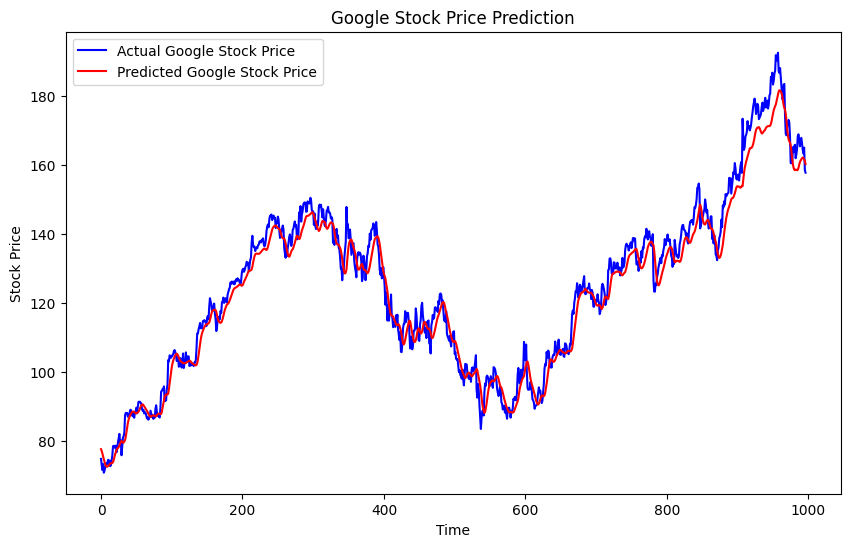

In [20]:
plt.figure(figsize=(10,6))
plt.plot(actual_prices, color='blue', label='Actual Google Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
# Create a plotly figure
fig = go.Figure()

# Add the actual prices to the plot
fig.add_trace(go.Scatter(
    x=data['Date'][len(data) - len(actual_prices):],
    y=actual_prices,
    mode='lines+markers',
    name='Actual Price',
    line=dict(color='royalblue', width=2),
    marker=dict(size=6, symbol='circle')
))

# Add the predicted prices to the plot
fig.add_trace(go.Scatter(
    x=data['Date'][len(data) - len(predicted_prices):],
    y=predicted_prices,
    mode='lines+markers',
    name='Predicted Price',
    line=dict(color='crimson', width=2, dash='dash'),
    marker=dict(size=6, symbol='x')
))

# Update layout for a modern look
fig.update_layout(
    title=dict(
        text="Google Stock Price Prediction",
        font=dict(size=24, color='white'),
        x=0.5
    ),
    xaxis_title="Date",
    yaxis_title="Stock Price (USD)",
    xaxis=dict(
        title_font=dict(size=18, color='white'),
        tickfont=dict(size=14, color='white'),
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title_font=dict(size=18, color='white'),
        tickfont=dict(size=14, color='white'),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title="Legend",
        font=dict(size=14, color='white'),
        x=0.8,
        y=0.9
    ),
    hovermode="x unified",
    template="plotly_dark",  # Modern dark theme
)

# Show the interactive plot
fig.show()